<a href="https://colab.research.google.com/github/aderdouri/ActuarialThesis/blob/master/Notebooks/DeepLearning/myPyTorchRegressor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Auto CHARGE Prediction : Pytorch Regressor

In [2]:
!rm -rf ActuarialThesis
!git clone https://github.com/aderdouri/ActuarialThesis.git
%ls -ltr ActuarialThesis

Cloning into 'ActuarialThesis'...
remote: Enumerating objects: 1105, done.
remote: Counting objects: 100% (388/388), done.
remote: Compressing objects: 100% (202/202), done.
remote: Total 1105 (delta 211), reused 347 (delta 184), pack-reused 717
Receiving objects: 100% (1105/1105), 133.44 MiB | 19.10 MiB/s, done.
Resolving deltas: 100% (501/501), done.
total 24
drwxr-xr-x 2 root root 4096 Nov 14 09:26 Data/
drwxr-xr-x 2 root root 4096 Nov 14 09:26 EMTboost/
drwxr-xr-x 6 root root 4096 Nov 14 09:26 Notebooks/
drwxr-xr-x 2 root root 4096 Nov 14 09:26 R/
drwxr-xr-x 2 root root 4096 Nov 14 09:26 src/
-rw-r--r-- 1 root root   54 Nov 14 09:26 README.md


In [3]:
!mkdir ActuarialThesis/plots_rgr
!ls -ltr ActuarialThesis/plots_rgr

total 0


In [4]:
# Ajouter le répértoire src
import sys
sys.path.insert(0,'./ActuarialThesis/src/')

In [5]:
import installHelper

In [6]:
# Installer les packages nécéssaires
%time installHelper.installALL()

CPU times: user 381 ms, sys: 61.7 ms, total: 443 ms
Wall time: 1min 49s


In [7]:
# On doit trouver tous les packages mentionés dans le grep
!pip list -v | grep -e catboost -e 'imbalanced-learn' -e 'optuna' -e 'catboost' -e 'lime' -e 'shap'

catboost                         1.2.2                 /usr/local/lib/python3.10/dist-packages pip
imbalanced-learn                 0.10.1                /usr/local/lib/python3.10/dist-packages pip
lime                             0.2.0.1               /usr/local/lib/python3.10/dist-packages pip
optuna                           3.4.0                 /usr/local/lib/python3.10/dist-packages pip
shap                             0.43.0                /usr/local/lib/python3.10/dist-packages pip
shapely                          2.0.2                 /usr/local/lib/python3.10/dist-packages pip


In [8]:
# Importer les packages nécéssaires
from helper import *

In [9]:
# Appliquer le theme par défaut
sns.set_theme()

In [10]:
# install torchsummary
!pip install -q torchsummary

In [46]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from torchvision import datasets
import torchvision.transforms as transforms

import seaborn as sns
from numpy import sum
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm
from torchsummary import summary

from torch import nn, optim
import torch.nn.functional as F

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import warnings
warnings.filterwarnings('ignore')

In [47]:
# Partir du dataset déja encodé et splité en Train/Test
df_train = pd.read_csv('ActuarialThesis/Data/encodedTrainBASEAUTO.csv')
df_test = pd.read_csv('ActuarialThesis/Data/encodedTestBASEAUTO.csv')
df_train.head()

,ACV,SEX,STATUT,AGECOND,K8000,RM,CAR_AUTRE,CAR_BER,CAR_BRK,CAR_CTE,...,SEGM_M2,GARAGE_1,GARAGE_2,GARAGE_3,CSP_1,CSP_50,CSP_55,CSP_60,CSP_AUTRE,CHARGE
0,-0.551995,1,0,2.524444,1,-0.817279,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.000000
1,-1.114303,0,0,0.762290,0,-0.817279,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.000000
2,0.853775,0,1,-1.067640,0,0.732469,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,2154.048943
3,-1.114303,0,0,-0.864314,0,-0.817279,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.000000
4,-1.395457,0,0,-1.067640,0,-0.300697,0.0,0.0,1.0,0.0,...,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,772.435649


## Loading the Dataset

In [211]:
X_train = df_train.drop('CHARGE', axis=1)
y_train = df_train['CHARGE']

X_test = df_test.drop('CHARGE', axis=1)
y_test = df_test['CHARGE']

# Split the train set into Train/Val sets: 80:20
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=13)

In [212]:
# create tensor datasets from df
train_features = torch.FloatTensor(X_train.to_numpy())
test_features = torch.FloatTensor(X_test.to_numpy())
val_features = torch.FloatTensor(X_val.to_numpy())

y_train = torch.FloatTensor(y_train)
y_test = torch.FloatTensor(y_test)
y_val = torch.FloatTensor(y_val.to_numpy())
trainDataset = TensorDataset(train_features, y_train)
testDataset = TensorDataset(test_features, y_test)
valDataset = TensorDataset(val_features, y_val)

# create dataloaders
batch_size = 1028
trainloader = DataLoader(trainDataset, batch_size=batch_size, shuffle=True)
testloader = DataLoader(testDataset, batch_size=batch_size, shuffle=True)
valloader = DataLoader(valDataset, batch_size=batch_size, shuffle=True)

In [213]:
#defining the network
class TweedieRegressor(nn.Module):
  def __init__(self, input_shape):
    super(TweedieRegressor, self).__init__()
    self.fc1 = nn.Linear(input_shape, 128)
    self.fc2 = nn.Linear(128, 256)
    self.fc3 = nn.Linear(256, 256)
    self.fc4 = nn.Linear(256, 256)
    self.fc5 = nn.Linear(256, 1)

    # Dropout module with 0.2 drop probability
    self.dropout = nn.Dropout(p=0.2)

  def forward(self,x):
    x = self.dropout(F.relu(self.fc1(x)))
    x = self.dropout(F.relu(self.fc2(x)))
    x = self.dropout(F.relu(self.fc3(x)))
    x = self.dropout(F.relu(self.fc4(x)))
    x = self.fc5(x)
    return x

In [214]:
class CustomTweedieLoss(nn.Module):
    def __init__(self, p):
        super(CustomTweedieLoss, self).__init__()
        self.p = p
    def forward(self, y_pred, y_true):
      loss = - y_true * torch.pow(y_pred, 1 - self.p) / (1 - self.p) \
        + torch.pow(y_pred, 2 - self.p) / (2 - self.p)
      return torch.mean(loss)

In [217]:
input_size = X_train.shape[1]
model = TweedieRegressor(input_shape= input_size)

#criterion = nn.MSELoss(reduction='mean')
criterion = CustomTweedieLoss(1.9)
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [223]:
epochs = 100
train_losses, val_losses = [], []
for e in range(epochs):
    running_loss = 0
    for data, target in trainloader:
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, target)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    else:
        val_loss = 0
        # Turn off gradients for validation, saves memory and computations
        with torch.no_grad():
            model.eval()
            for data, target in valloader:
                outputs = model(data)
                val_loss += criterion(outputs, target)

        model.train()

        train_losses.append(running_loss/len(trainloader))
        val_losses.append(val_loss/len(testloader))

        print("Epoch: {}/{}.. ".format(e+1, epochs),
              "Training Loss: {:.3f}.. ".format(train_losses[-1]),
              "Test Loss: {:.3f}.. ".format(val_losses[-1]))

Epoch: 1/100..  Training Loss: 25.518..  Test Loss: 18.463.. 
Epoch: 2/100..  Training Loss: 24.480..  Test Loss: 17.569.. 
Epoch: 3/100..  Training Loss: 23.743..  Test Loss: 16.749.. 
Epoch: 4/100..  Training Loss: 22.917..  Test Loss: 16.084.. 
Epoch: 5/100..  Training Loss: 22.411..  Test Loss: 15.632.. 
Epoch: 6/100..  Training Loss: 21.718..  Test Loss: 15.299.. 
Epoch: 7/100..  Training Loss: 21.393..  Test Loss: 14.820.. 
Epoch: 8/100..  Training Loss: 20.901..  Test Loss: 14.722.. 
Epoch: 9/100..  Training Loss: 20.530..  Test Loss: 14.615.. 
Epoch: 10/100..  Training Loss: 20.329..  Test Loss: 14.159.. 
Epoch: 11/100..  Training Loss: 20.116..  Test Loss: 14.050.. 
Epoch: 12/100..  Training Loss: 19.994..  Test Loss: 13.868.. 
Epoch: 13/100..  Training Loss: 19.775..  Test Loss: 13.767.. 
Epoch: 14/100..  Training Loss: 19.721..  Test Loss: 13.661.. 
Epoch: 15/100..  Training Loss: 19.668..  Test Loss: 13.505.. 
Epoch: 16/100..  Training Loss: 19.648..  Test Loss: 13.466.. 
E

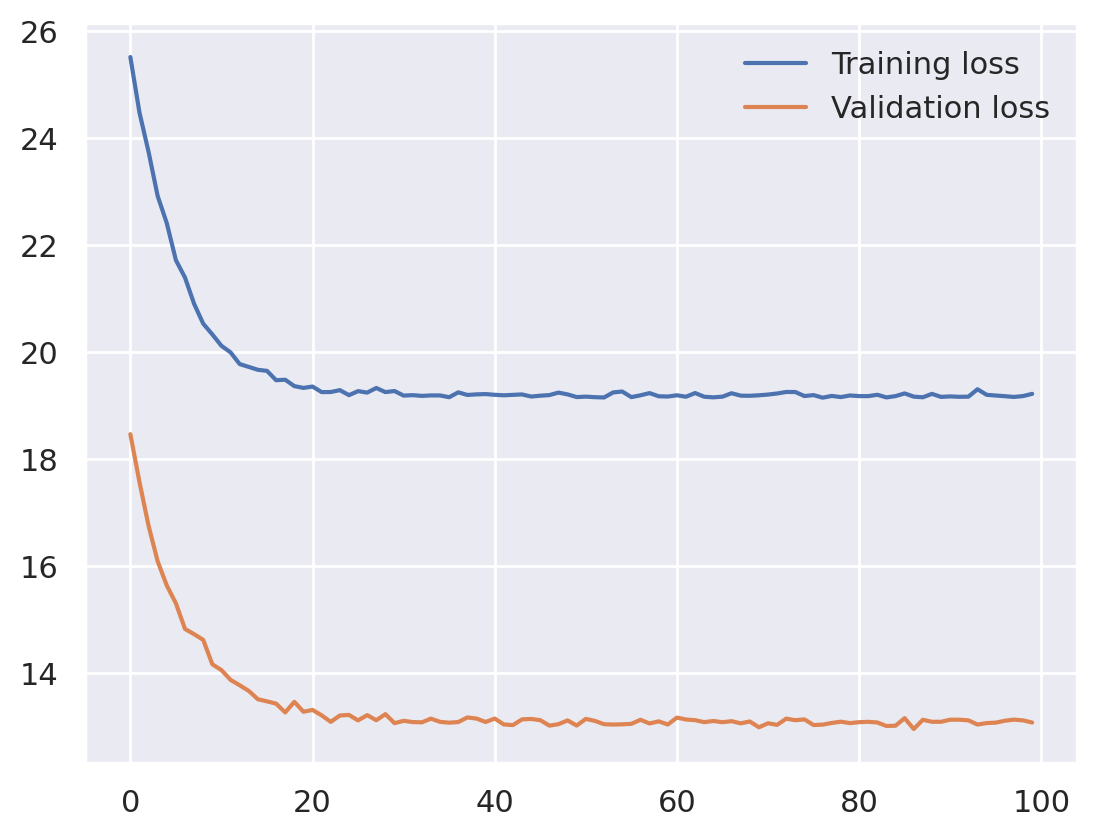

In [224]:
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend(frameon=False)

## Inference

In [225]:
model.eval()
y_pred = model.forward(torch.FloatTensor(X_test.to_numpy())).reshape(-1).detach().numpy()

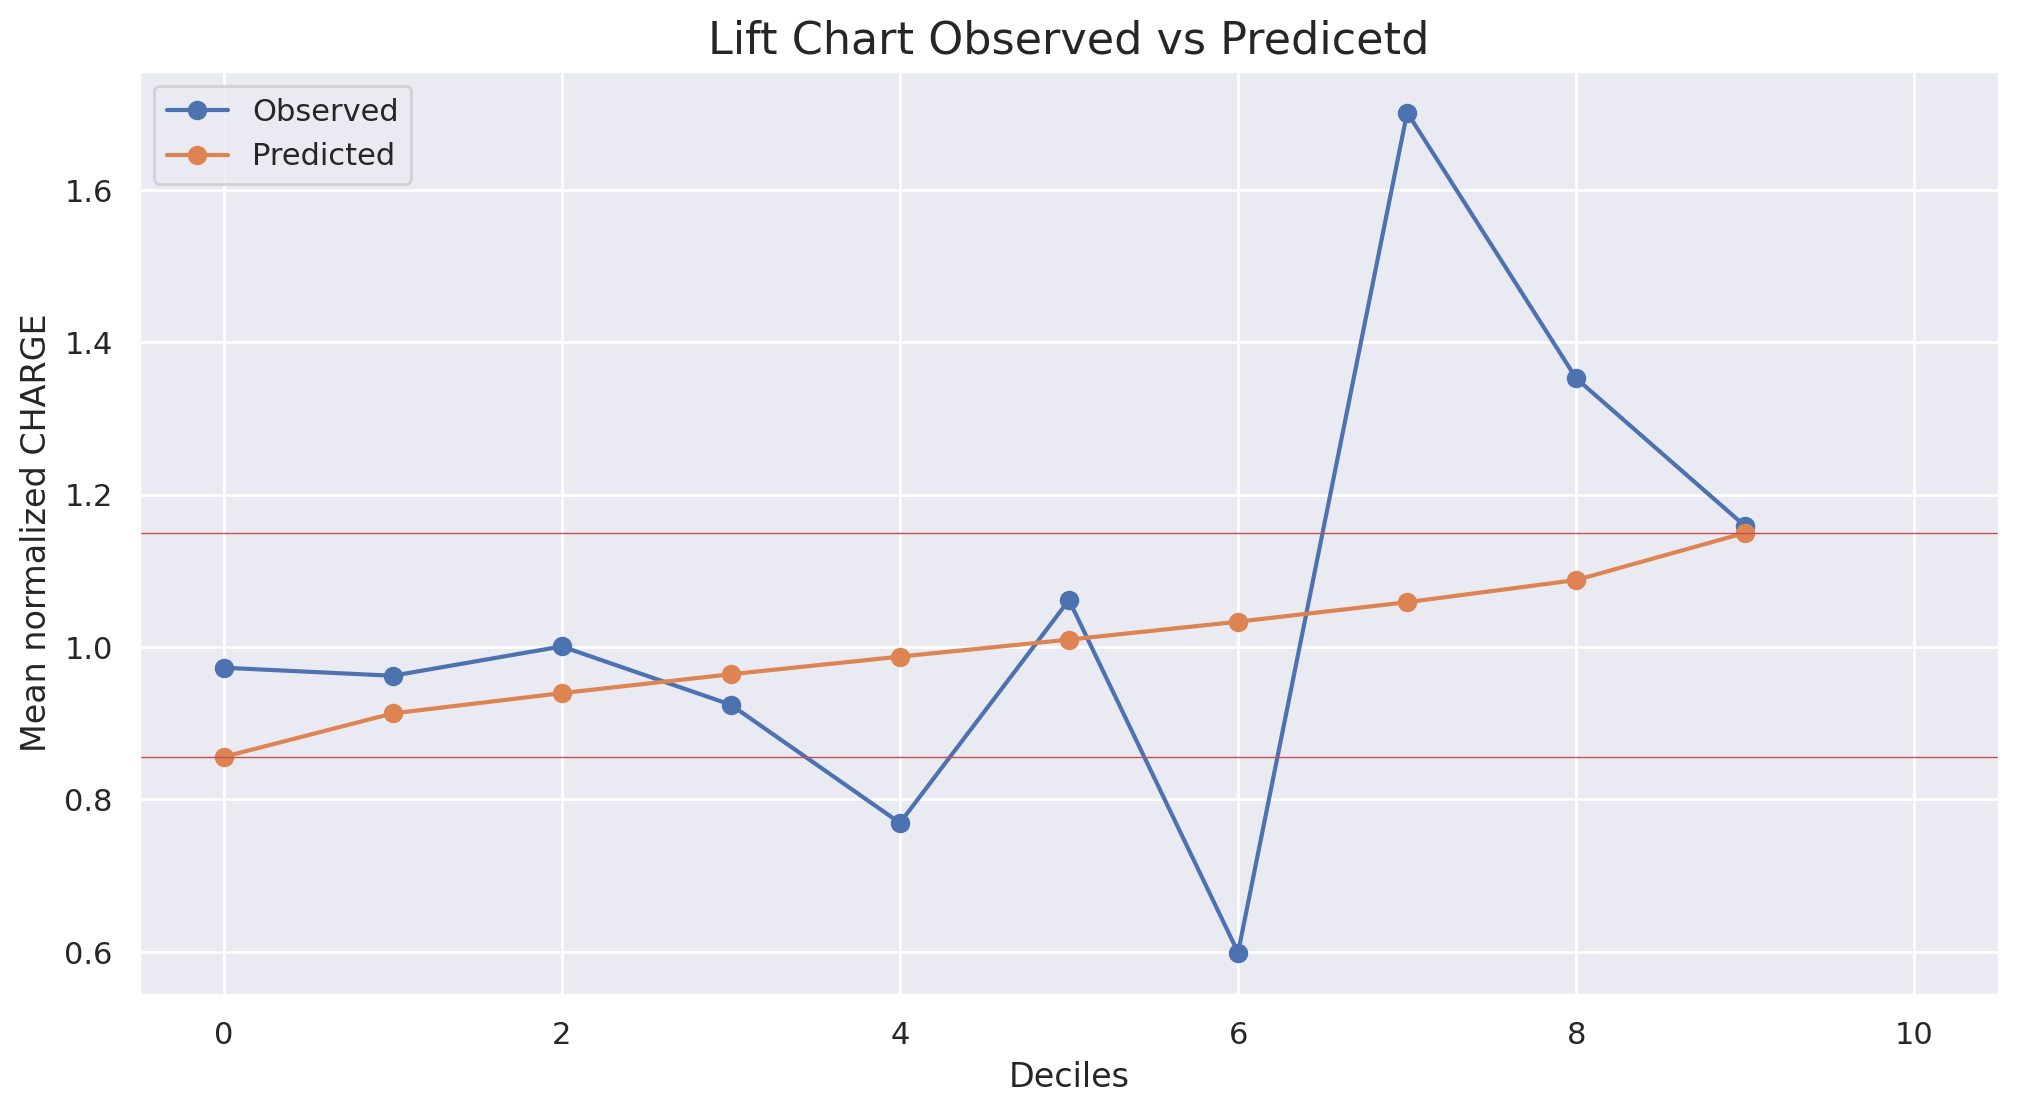

In [226]:
df_ObsVsPred = df_ObservedVsPredicted(y_test, y_pred)
fig, ax = plotLiftChart(df_ObsVsPred)
fig.savefig('./ActuarialThesis/plots_rgr/myCatBoostRegressorLiftChart.pdf')

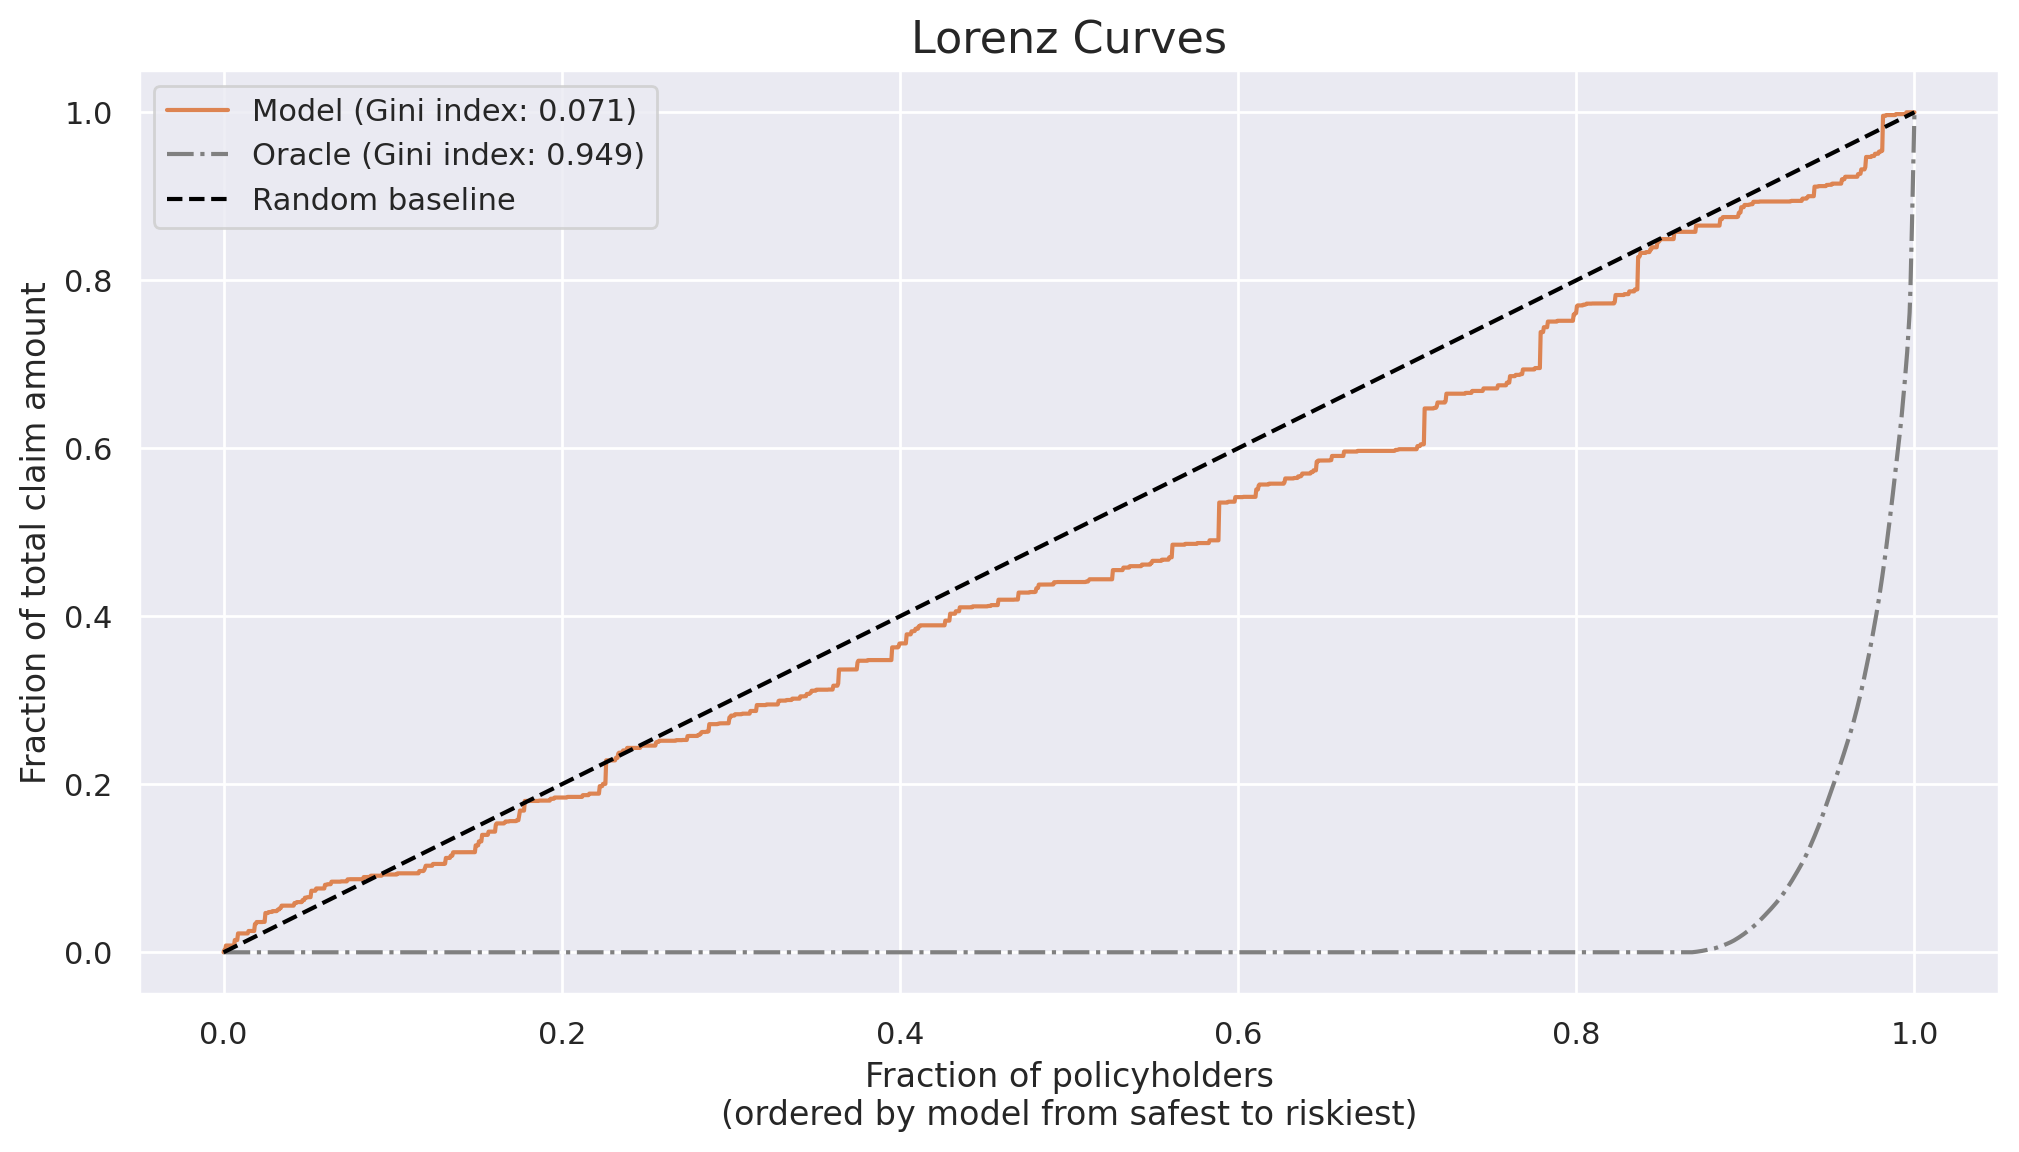

In [227]:
df_ObsVsPred = df_ObservedVsPredicted(y_test, y_pred)
fig, ax = plotLorenzCurve(df_ObsVsPred)
fig.savefig('./ActuarialThesis/plots_rgr/myCatBoostRegressorLorenzCurve.pdf')